For this notebook we need to add seaborn

In [3]:
%pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 330.3 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 751.6 kB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt
import xarray as xr
import seaborn as sns

In [14]:
pm.__version__

'5.8.0'

Selected Exercises from Chapter 7

Exercise 3: 
Read and run through the following examples about mixture models from the PyMC documentation:

Marginalized Gaussian mixture model: https://www.pymc.io/projects/examples/en/latest/mixture_models/marginalized_gaussian_mixture_model.html

Dependent density regression: https://www.pymc.io/projects/examples/en/latest/mixture_models/dependent_density_regression.html

### First, the marginalized mixture model examples

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Synthetic mixtures.. This generates 1000 points which are drawn from the mixture

In [6]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])


component = rng.choice(MU.size, size=N, p=W)
x = rng.normal(MU[component], SIGMA[component], size=N)

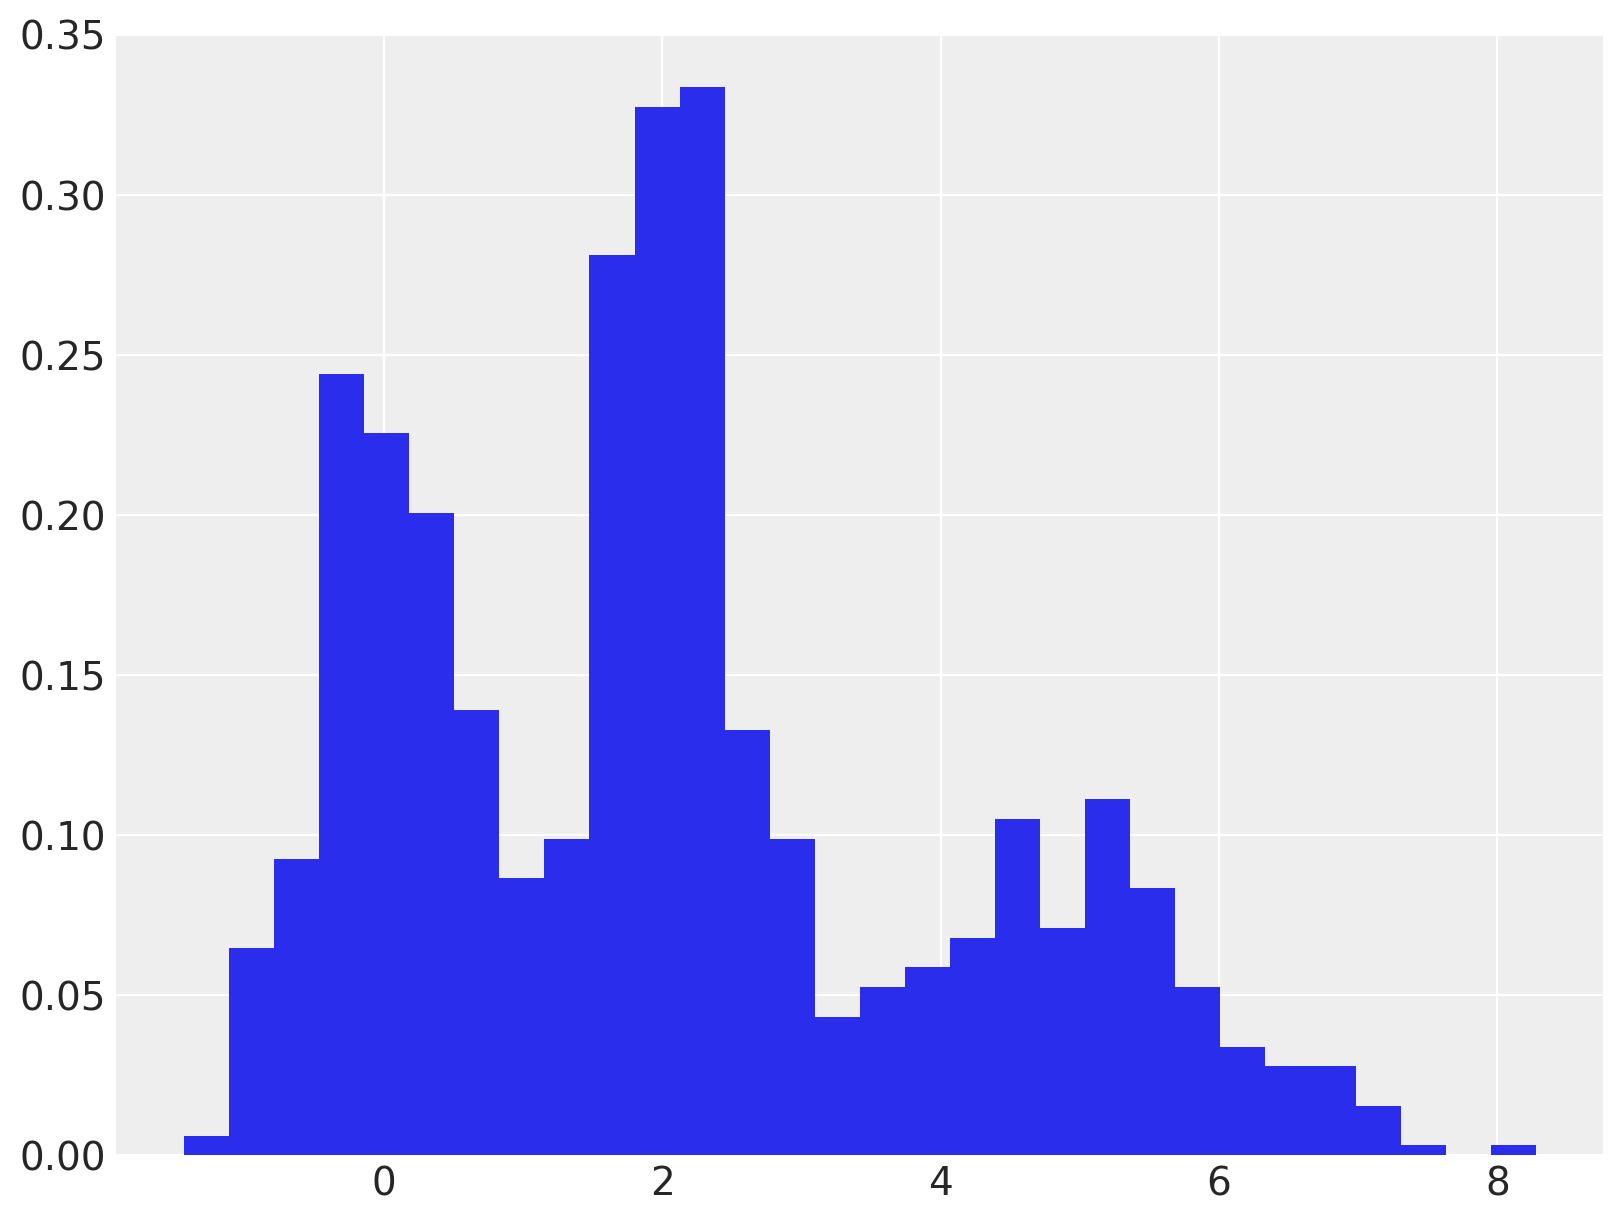

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, density=True, lw=0);

In [17]:
with pm.Model(coords={"cluster": np.arange(len(W)), "obs_id": np.arange(N)}) as model:
    w = pm.Dirichlet("w", np.ones_like(W))

    mu = pm.Normal(
        "mu",
        np.zeros_like(W),
        1.0,
        dims="cluster",
        transform=pm.distributions.transforms.univariate_ordered,
        testval=[1, 2, 3],
    )
    tau = pm.Gamma("tau", 1.0, 1.0, dims="cluster")

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=x, dims="obs_id")

C:\Users\rjljr\AppData\Local\Temp\ipykernel_14940\1307959232.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  mu = pm.Normal(


In [ ]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, return_inferencedata=True)


In [ ]:

    # sample posterior predictive samples
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"] ) #, keep_size=True)

 

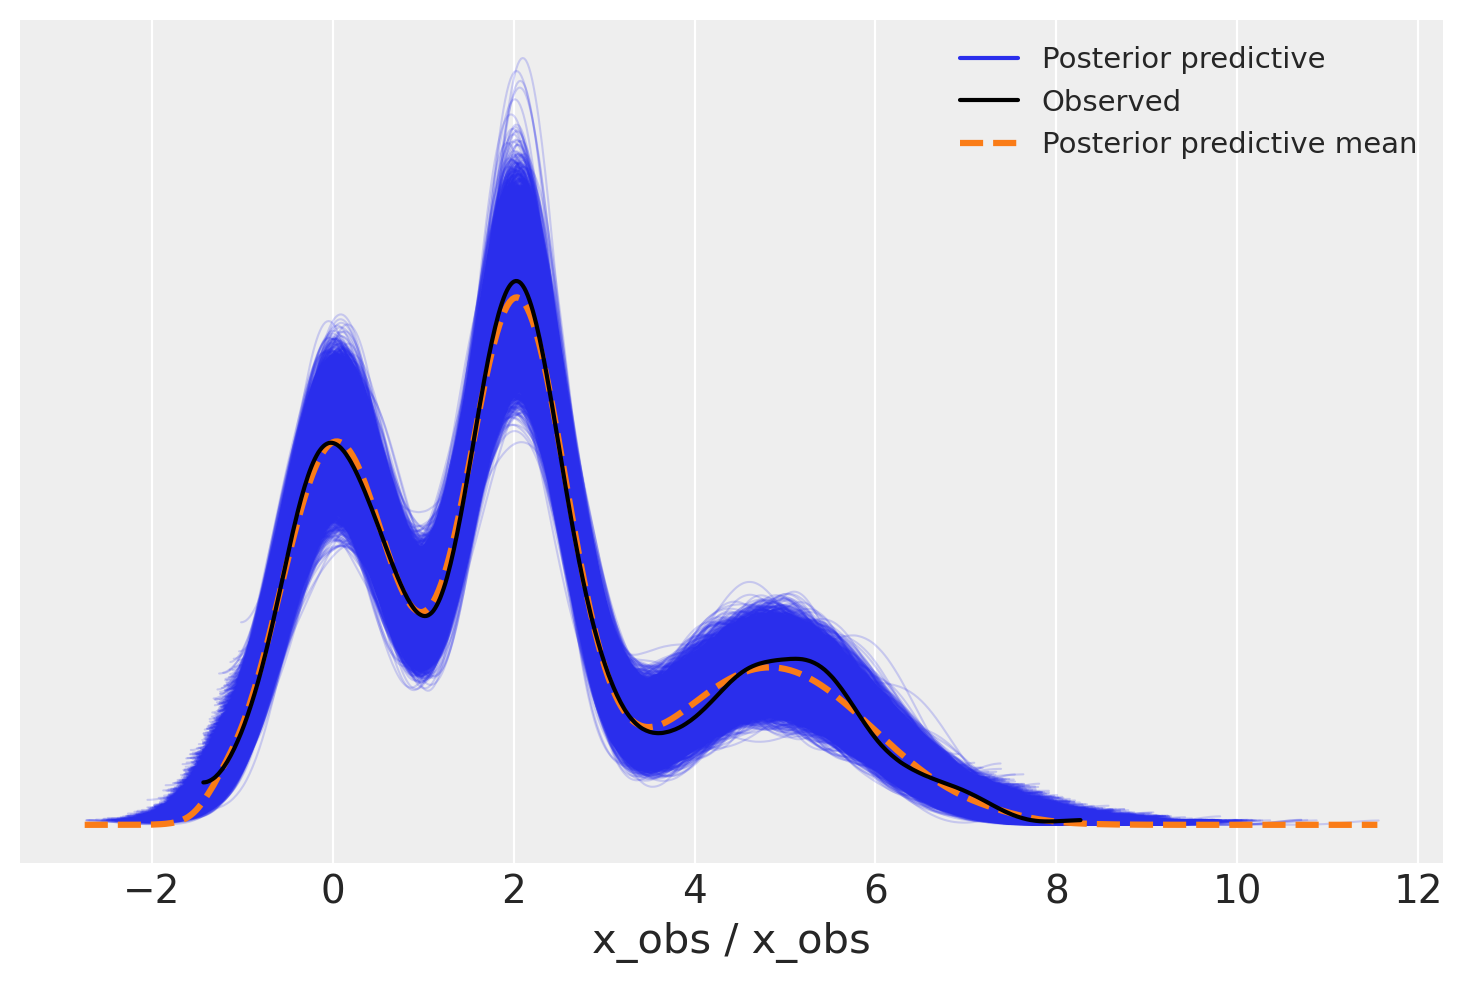

In [21]:
az.plot_ppc(ppc_trace);

I am not going to bother with the Dependant Density Regression example as it has not been updated and still uses Theano an PYMC3.   You know what is great about PYMC? It is under active development, getting better all the time. Also, that is what sucks about PYMC. Constantly moving API.

## Exercise 5
I am going to try to fit the previous data with a Dirichlet Process

In [44]:
K = 5
def stick_breaking(alpha, K): 
    beta = pm.Beta('beta', 1., alpha, shape=K) 
    w = beta * pt.concatenate([[1.], pt.extra_ops.cumprod(1. - beta)[:-1]]) + 1E-6 
    return w/w.sum()

In [49]:
with pm.Model() as model_DP: 
    alpha = pm.Gamma('alpha', 2, 1) 
    w = pm.Deterministic('w', stick_breaking(alpha, K)) 
    means = pm.Normal('means', 
                      mu=np.linspace(x.min(),x.max(), K), 
                      sigma=5, shape=K, 
                      transform=pm.distributions.transforms.univariate_ordered, 
                     ) 
 
    sd = pm.Exponential('sd', 0.5, shape=K) 
    obs = pm.NormalMixture('obs', w, means, sigma=sd, observed=x) 
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 480 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


In [50]:
az.summary(idata, var_names=['alpha', 'means','w'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.606,1.369,0.102,4.166,0.271,0.194,16.0,95.0,1.19
means[0],-8.206,5.558,-15.642,0.173,2.394,1.794,7.0,32.0,1.53
means[1],0.537,0.865,-0.029,2.065,0.430,0.330,7.0,30.0,1.53
means[2],2.742,1.226,1.965,4.948,0.610,0.467,7.0,29.0,1.53
means[3],6.424,2.944,4.509,12.638,1.345,1.016,7.0,29.0,1.53
means[4],17.995,4.002,10.762,25.468,0.744,0.534,29.0,1533.0,1.09
w[0],0.085,0.146,0.000,0.348,0.073,0.056,7.0,29.0,1.53
w[1],0.354,0.035,0.305,0.426,0.015,0.012,7.0,30.0,1.52
w[2],0.369,0.070,0.233,0.441,0.033,0.025,7.0,32.0,1.53
w[3],0.190,0.110,0.000,0.277,0.055,0.042,7.0,33.0,1.53


([], [])

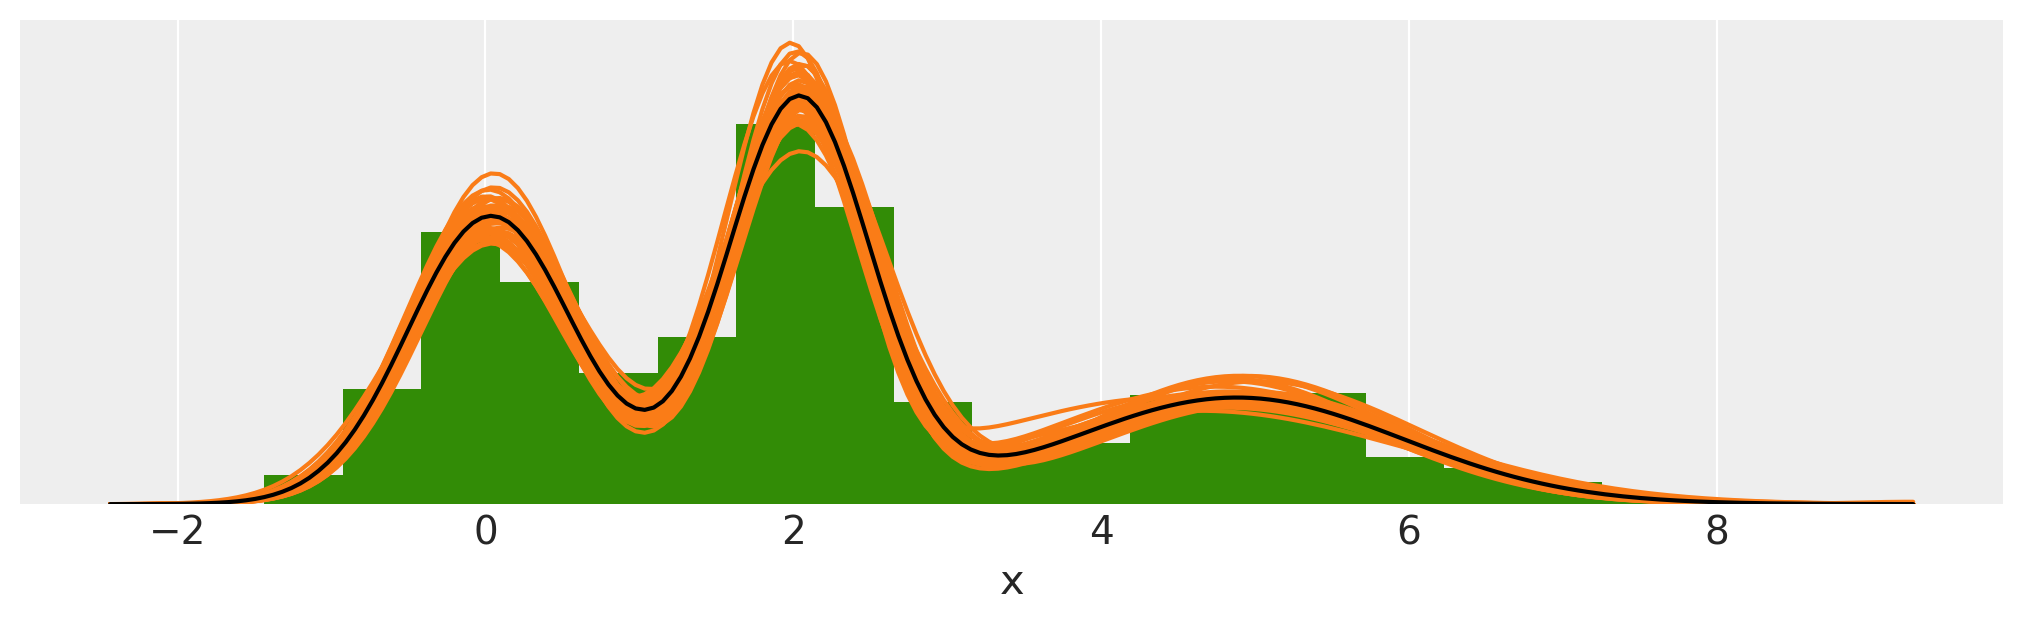

In [51]:
x_plot = np.linspace(x.min()-1,x.max()+1, 200)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = pz.Normal(posterior['means'].values[:, np.newaxis, :],
                              posterior['sd'].values[:, np.newaxis, :]).pdf(np.atleast_3d(x_plot))
post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)
plt.figure(figsize=(10, 3))

plt.hist(x, bins="auto", density=True, color="C2")
plt.plot(x_plot, post_pdfs[:,::100], c='C1')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])
 

I This thing is a a bear to sample (ESS is only in the 10s) but I don't plan to use it anytime soon. Hopefully whenever it comes up I rememebr it even exists!  And use this: https://www.pymc.io/projects/examples/en/latest/mixture_models/dp_mix.html